In [311]:
import pandas as pd
import numpy as np
import datetime
import os
import fiona
import rasterio as rio
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from scipy import stats
import cmocean

In [346]:
# load the centerline file ########################
clinepath = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/centerlines/'
for file in os.listdir(clinepath):
    if file.endswith('.shp'):
        print(file)
cfile = 'centerline_n_utm07_250m_circlebuffer.shp'
########################################################

print(); print(cfile, 'chosen')

if '_n_' in cfile:
    northline = True
    newfolder = 'centerline-north'
else:
    northline = False
    newfolder = 'centerline-south'
print(northline)

# read with geopandas
cline_gdf = gpd.read_file(clinepath+cfile)
geoms = cline_gdf.geometry.values
cline_gdf

centerline_s_utm07_250m_squarebuffer.shp
centerline_n_utm07_250m_circlebuffer.shp
centerline_n_utm07_250m.shp
centerline_n_utm07_250m_squarebuffer.shp
centerline_s_utm07_250m_circlebuffer.shp
centerline_s_utm07_500m_circlebuffer.shp
centerline_n_utm07_500m_circlebuffer.shp
centerline_n_utm07_121pts.shp
centerline_n_utm07_500m.shp
centerline_n_final_wgs84.shp
centerline_s_final_wgs84.shp
centerline_n_final_utm07.shp
centerline_s_final_utm07.shp
centerline_s_utm07_250m.shp

centerline_n_utm07_250m_circlebuffer.shp chosen
True


,id,distance,angle,geometry
0,None,100.0,120.762720,"POLYGON ((560860.191 6672605.735, 560854.073 6..."
1,None,350.0,120.762720,"POLYGON ((561075.015 6672477.864, 561068.897 6..."
2,None,600.0,120.762720,"POLYGON ((561289.838 6672349.993, 561283.720 6..."
3,None,850.0,111.317912,"POLYGON ((561512.949 6672239.084, 561506.831 6..."
4,None,1100.0,111.317912,"POLYGON ((561745.843 6672148.199, 561739.725 6..."
...,...,...,...,...
116,None,29100.0,119.116146,"POLYGON ((578501.133 6654291.947, 578495.015 6..."
117,None,29350.0,119.116146,"POLYGON ((578719.542 6654170.301, 578713.424 6..."
118,None,29600.0,118.610460,"POLYGON ((578938.435 6654049.534, 578932.317 6..."
119,None,29850.0,118.610460,"POLYGON ((579157.909 6653929.821, 579151.791 6..."


# Extract elevation differences:

In [347]:
dem_diff_path = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/final-DEMs/differenced_DEMs/upper_glacier/'

# grab differenced DEM info:
ds1s = []; ds2s = []; fnames = []
for file in os.listdir(dem_diff_path):
    if file.endswith('.tif'):
        split = file.split('_') # split filename
        ds1 = split[0]; ds2 = split[1]
        
        if ds2.endswith('.tif'):
            ds2 = ds2[:-4] # remove extension
        ds2s.append(ds1); ds1s.append(ds2); fnames.append(file)
        
dem_df = pd.DataFrame(list(zip(ds1s, ds2s, fnames)), columns=['ds1','ds2','fname'])
dem_df = dem_df.sort_values(by='ds1'); dem_df.reset_index(drop=True)

,ds1,ds2,fname
0,20131207,20140318,20140318_20131207.tif
1,20140318,20200605,20200605_20140318.tif
2,20140318,20190430,20190430_20140318.tif
3,20140318,20151031,20151031_20140318.tif
4,20151031,20160717,20160717_20151031.tif
5,20160717,20180128,20180128_20160717_2018merged.tif
6,20180128,20190430,20190430_20180128_2018merged.tif
7,20190430,20200605,20200605_20190430.tif


20140318_20131207.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_64473/2674620016.py:15: RuntimeWarning: Mean of empty slice
  mean_diffs.append(np.nanmean(crop_array))


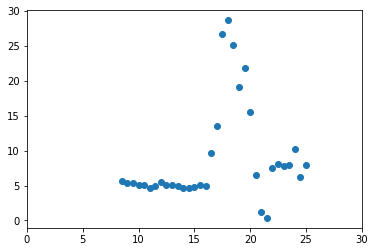

61
20200605_20140318.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_64473/2674620016.py:15: RuntimeWarning: Mean of empty slice
  mean_diffs.append(np.nanmean(crop_array))


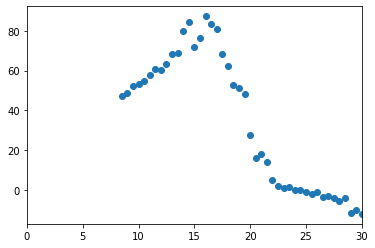

61
20190430_20140318.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_64473/2674620016.py:15: RuntimeWarning: Mean of empty slice
  mean_diffs.append(np.nanmean(crop_array))


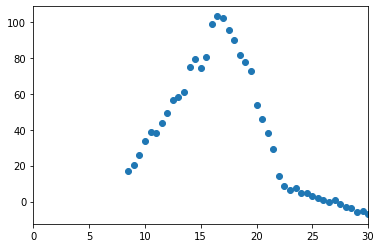

61
20151031_20140318.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_64473/2674620016.py:15: RuntimeWarning: Mean of empty slice
  mean_diffs.append(np.nanmean(crop_array))


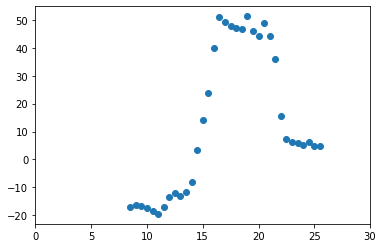

61
20160717_20151031.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_64473/2674620016.py:15: RuntimeWarning: Mean of empty slice
  mean_diffs.append(np.nanmean(crop_array))


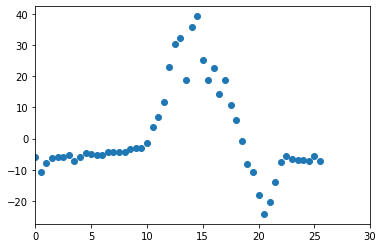

61
20180128_20160717_2018merged.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_64473/2674620016.py:15: RuntimeWarning: Mean of empty slice
  mean_diffs.append(np.nanmean(crop_array))


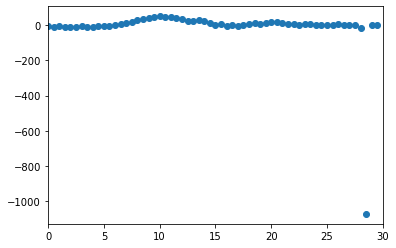

61
20190430_20180128_2018merged.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_64473/2674620016.py:15: RuntimeWarning: Mean of empty slice
  mean_diffs.append(np.nanmean(crop_array))


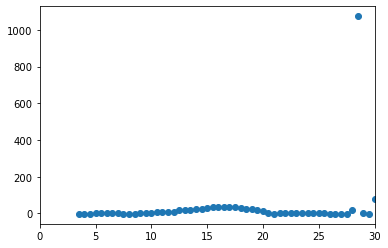

61
20200605_20190430.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_64473/2674620016.py:15: RuntimeWarning: Mean of empty slice
  mean_diffs.append(np.nanmean(crop_array))


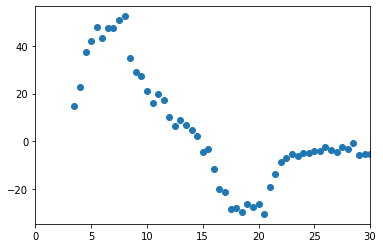

61


In [201]:
for idx, row in dem_df.iterrows():
        print(row.fname)
        src = rio.open(dem_diff_path+row.fname); elev_diff = src.read(1); affine=src.transform
        
        dists = []; mean_diffs = []
        for idx2, row2 in cline_gdf.iterrows():
            geom = row2.geometry
            dist = row2.distance
            dists.append(dist)
            try:
                out_image, out_transform = mask(src, [mapping(geom)], crop=True)
                crop_array = out_image[0,:,:]
                crop_array[crop_array < -1e30] = np.NaN
#                 print(dist, np.nanmean(crop_array))
                mean_diffs.append(np.nanmean(crop_array))
            except Exception:
                mean_diffs.append(np.NaN)
#                 print(dist, 'no overlap')
                pass
        mean_diffs = np.array(mean_diffs); dists = np.array(dists)
    
        # calculate change in driving stress from elevation differences
        rho = 917 # kg/m3
        g = 9.81 #m/s2
        driving_stress = rho*g*mean_diffs
        
        if northline: # flip distances for northern centerline
            dists = np.flip(dists)
        mean_diffs[mean_diffs == 0] = np.NaN # differences should never be exactly 0
        plt.plot(dists/1000, mean_diffs, 'o')
        plt.xlim(0, 30)
        plt.show()
        
        # write centerline data to csv
        new_df = pd.DataFrame(list(zip(dists, mean_diffs, driving_stress)), columns=['dist_m','mean_elev_diff', 'change_in_driving_stress_Pa'])
        print(len(new_df))
        new_df.to_csv(dem_diff_path+newfolder+'/profile_'+row.ds1+'_'+row.ds2+'.csv')   

## Plot all elevation difference profiles colored by year

In [202]:
# grab the profiles in order
filenames = []
nofiles = 0 # number of files
for file in os.listdir(dem_diff_path+newfolder):
    if file.startswith('profile') and file.endswith('csv'):
        filenames.append(file)
        nofiles+=1
filenames.sort()
print(filenames)

['profile_20131207_20140318.csv', 'profile_20140318_20151031.csv', 'profile_20151031_20160717.csv', 'profile_20160717_20180128.csv', 'profile_20180128_20190430.csv', 'profile_20190430_20200605.csv']


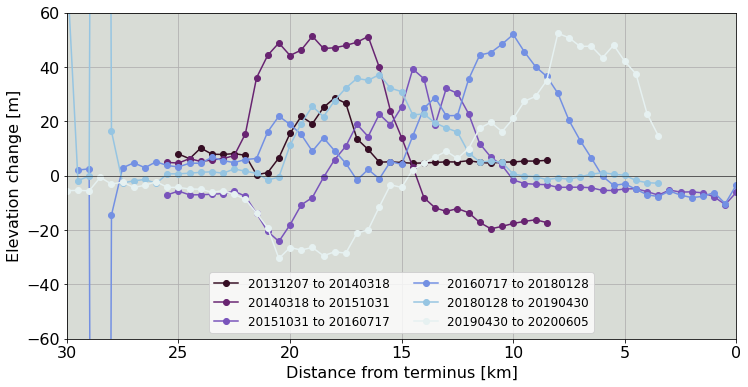

In [203]:
fig, ax = plt.subplots(figsize=(12,6))
fs = 16
# background_col='xkcd:pale grey'
background_col='xkcd:light grey'
# ax.set_facecolor(background_col)
colors = cmocean.cm.dense_r(np.linspace(0,1,nofiles))

legends = []
a = 0
for filename in filenames:
    [pre, ds1, ds2] = filename.split('_') # grab dates
    ds2 = ds2[:-4] # cut off the .csv
    timeperiod = ds1+' to '+ds2
    legends.append(timeperiod)
      
    df = pd.read_csv(dem_diff_path+newfolder+'/'+filename)
        
    ax.plot(df.dist_m/1000, df.mean_elev_diff, 'o-', color=colors[a])
    a += 1

ax.set_xlim(30,0)
ax.set_xlabel('Distance from terminus [km]', fontsize=fs)
ax.plot([30, 0], [0, 0], 'k-', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_ylim([-60,60])
ax.set_ylabel('Elevation change [m]', fontsize=fs)
ax.legend(legends, loc='lower center', ncol=2, fontsize=fs-4)
ax.grid()
ax.set_facecolor(background_col)
plt.show()       

## Plot cumulative elevation change

In [360]:
ds1s = ['20131207','20140318','20151031','20160717', '20180128','20190430']
ds2s = ['20140318','20151031','20160717', '20180128','20190430','20200605']
slope_changes = [0.039550-0.043928, 0.046243 - 0.039550, 0.048950 - 0.046243, 0.051859 - 0.048950, 
                 0.053484 - 0.051859, 0.053592 - 0.053484] #20180128 through 20200605
ss_td_df = pd.DataFrame(list(zip(ds1s, ds2s, slope_changes)),columns=['ds1','ds2','slope_change'])
ss_td_df

,ds1,ds2,slope_change
0,20131207,20140318,-0.004378
1,20140318,20151031,0.006693
2,20151031,20160717,0.002707
3,20160717,20180128,0.002909
4,20180128,20190430,0.001625
5,20190430,20200605,0.000108


In [361]:
ds1

'20190430'

In [358]:
ss_td_df[ss_td_df.ds1 == ds1]

,ds1,ds2,slope_change


20131207 20140318 28.649188995361328
20140318 20151031 51.34003829956055
20151031 20160717 39.2645263671875
20160717 20180128 51.969147
[ 0.0000000e+00  2.0605950e+00  2.5508184e+00 -1.0735189e+03
 -1.4462632e+01  2.9017265e+00  4.7482120e+00  2.9491959e+00
  5.1363430e+00  3.7635903e+00  3.2177742e+00  4.6116114e+00
  4.5915090e+00  6.7831280e+00  5.5645804e+00  4.8272440e+00
  5.9659123e+00  6.3347807e+00  1.6137693e+01  2.1912350e+01
  1.8898970e+01  1.5178454e+01  9.0107230e+00  1.3962013e+01
  9.1429840e+00  4.5598907e+00 -1.6046710e+00  2.3116136e+00
 -1.1488944e+00  5.2055070e+00  4.1739800e+00  1.4637348e+01
  2.4874287e+01  2.8762262e+01  2.2080456e+01  2.2141758e+01
  3.5451363e+01  4.4403694e+01  4.5320900e+01  4.8412150e+01
  5.1969147e+01  4.5584038e+01  4.0134575e+01  3.6554214e+01
  3.0310995e+01  2.0333672e+01  1.2954581e+01  6.5283985e+00
 -2.0198797e-01 -3.5420060e+00 -2.9965353e+00 -4.9997377e+00
 -7.0030540e+00 -7.6779630e+00 -5.6108710e+00 -7.1402574e+00
 -8.057961

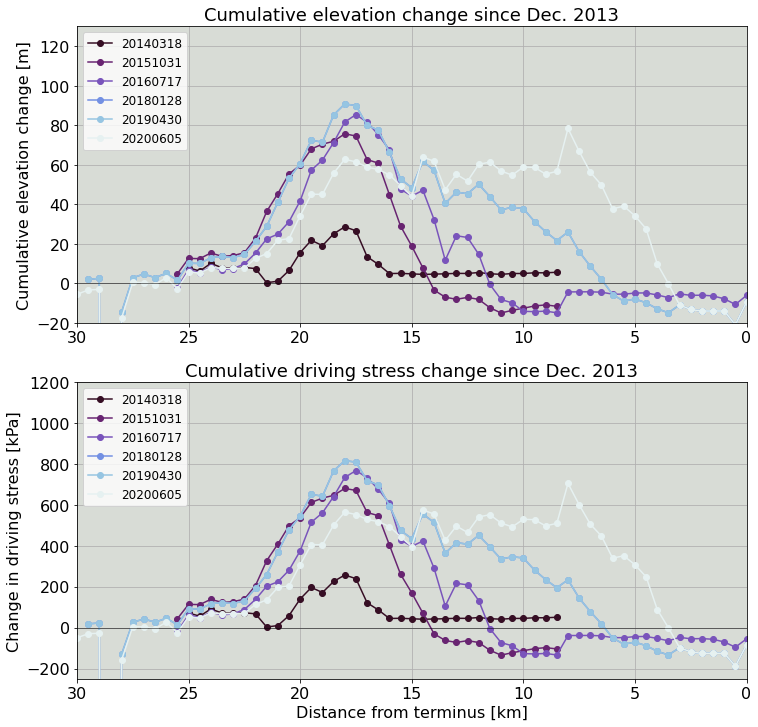

In [448]:
fig, (ax, ax2) = plt.subplots(2,1,figsize=(12,12))
fs = 16
# background_col='xkcd:pale grey'
background_col='xkcd:light grey'
colors = cmocean.cm.dense_r(np.linspace(0,1,nofiles))
legends = []
a = 0

ds1s = []; ds2s = []; max_increase_driving_stress = []
for filename in filenames:
    [pre, ds1, ds2] = filename.split('_') # grab dates
    ds2 = ds2[:-4] # cut off the .csv
    timeperiod = ds2
    legends.append(timeperiod)
    
    # grab the slope change
    slope_change = float(ss_td_df[ss_td_df.ds1 == ds1].slope_change)
      
    df = pd.read_csv(dem_diff_path+newfolder+'/'+filename)
    if a == 0:
        elev_diff = np.array(df.mean_elev_diff)
        elev_diff[np.isnan(elev_diff)] = 0
        cumulative_elev_diff = elev_diff
    elif ds1 == '20180128':
        print(elev_diff)
    else:
        elev_diff = np.array(df.mean_elev_diff)
        elev_diff[np.isnan(elev_diff)] = 0
        cumulative_elev_diff = cumulative_elev_diff + elev_diff
    print(ds1,ds2,np.nanmax(elev_diff))
    max_driving_stress = np.nanmax(elev_diff*9.81*917/1000); 
    max_increase_driving_stress.append(max_driving_stress); ds1s.append(ds1); ds2s.append(ds2)
    nan_cumulative_elev = cumulative_elev_diff.copy() # copy the cumulative_elev_diff
    nan_cumulative_elev[cumulative_elev_diff == 0] = np.NaN
#     ax.plot(df.dist_m/1000, cumulative_elev_diff, 'o-', color=colors[a])
    ax.plot(df.dist_m/1000, nan_cumulative_elev, 'o-', color=colors[a])
    ax2.plot(df.dist_m/1000, nan_cumulative_elev*9.81*917/1000, 'o-', color=colors[a])
    a += 1

ax.set_xlim(30,0)
ax.plot([30, 0], [0, 0], 'k-', linewidth=0.5);
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_ylim([-20,130])
ax.set_ylabel('Cumulative elevation change [m]', fontsize=fs)
ax.legend(legends, loc='upper left', ncol=1, fontsize=fs-4) 

ax2.set_xlim(30,0)
ax2.set_ylim(-250,1200)
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.plot([30, 0], [0, 0], 'k-', linewidth=0.5)
ax2.set_xlabel('Distance from terminus [km]', fontsize=fs)
ax2.set_ylabel('Change in driving stress [kPa]', fontsize=fs)
ax2.legend(legends, loc='upper left', ncol=1, fontsize=fs-4)


ax.grid(); ax2.grid()
ax.set_facecolor(background_col); ax2.set_facecolor(background_col)
ax.set_title('Cumulative elevation change since Dec. 2013',fontsize=fs+2)
ax2.set_title('Cumulative driving stress change since Dec. 2013',fontsize=fs+2)
# fig.savefig(dem_outpath+'figures/cumulative_driving_stress_quiescence_wslope.png', dpi=200)
plt.show()       

In [449]:
max_ds_df = pd.DataFrame(list(zip(ds1s, ds2s, max_increase_driving_stress)), columns=['ds1','ds2','max_increase_ds_kPa'])
max_ds_df


,ds1,ds2,max_increase_ds_kPa
0,20131207,20140318,257.721515
1,20140318,20151031,461.843176
2,20151031,20160717,353.214648
3,20160717,20180128,467.502494
4,20180128,20190430,467.502494
5,20190430,20200605,471.317537


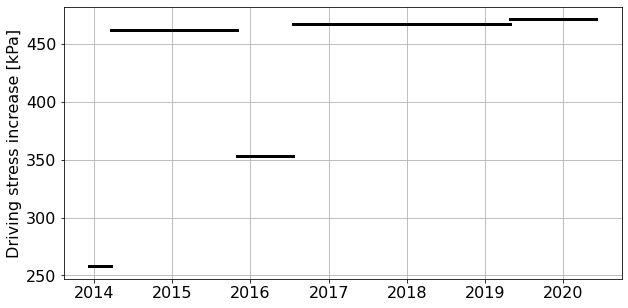

In [450]:
fig, ax = plt.subplots(figsize=(10,5))
for idx, row in max_ds_df.iterrows():
    d1 = datetime.datetime.strptime(row.ds1, '%Y%m%d')
    d2 = datetime.datetime.strptime(row.ds2, '%Y%m%d')
    ax.plot([d1, d2], [row.max_increase_ds_kPa, row.max_increase_ds_kPa],'k-',linewidth=3)

ax.grid()
ax.tick_params(axis='both',labelsize=fs)
ax.set_ylabel('Driving stress increase [kPa]', fontsize=fs)
fig.savefig(dem_outpath+'figures/increase_driving_stress_quiescence_noslope.png', dpi=200)
plt.show()

## Plot one driving stress profile

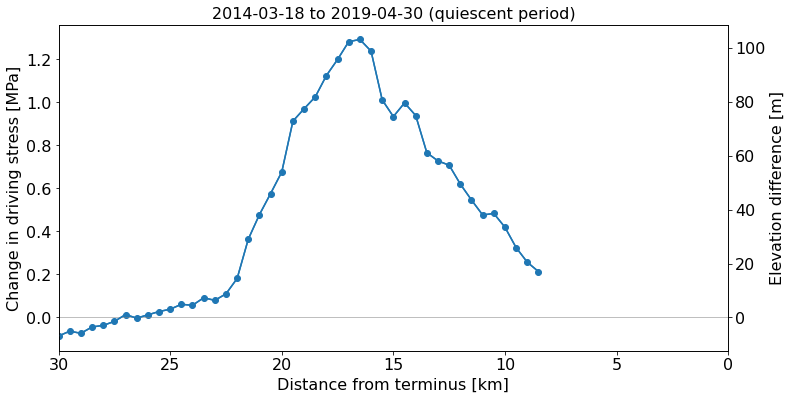

In [436]:
prof_df = pd.read_csv(dem_diff_path+newfolder+'/total_quiescent/profile_20140318_20190430.csv')
fs = 16

fig, ax = plt.subplots(figsize=(12,6))
twin1 = ax.twinx()

ax.plot(prof_df.dist_m/1000, prof_df.change_in_driving_stress_Pa*(0.053484 - 0.039550)/10000, 'o-')
ax.plot([30, 0], [0, 0], '-', color='gray',linewidth=0.5)
# plt.plot([30, 0], [0, 0], '-', color='gray',linewidth=0.5)
ax.set_ylabel('Change in driving stress [MPa]',fontsize=fs)
ax.set_xlabel('Distance from terminus [km]',fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
plt.title('2014-03-18 to 2019-04-30 (quiescent period)', fontsize=fs)
ax.set_xlim(30,0)

twin1.plot(prof_df.dist_m/1000, prof_df.mean_elev_diff,'-')
twin1.set_ylabel('Elevation difference [m]',fontsize=fs)
twin1.tick_params(axis='both', which='major', labelsize=fs)
fig.savefig(dem_outpath+'figures/total_driving_stress_quiescence_wslope.png', dpi=200)
plt.show()

## Plot bed elevations:

In [212]:
# sIPR
sIPR_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/bed/sIPR/sIPR_proj_data.csv')
sIPR_df.head()

,sIPR_UTMx_proj,sIPR_UTMy_proj,sIPR_dist_km_proj,Pick_depth
0,570661.311252,6.658280e+06,0.357101,-357.03
1,570662.688259,6.658279e+06,1.936953,-356.68
2,570664.025658,6.658278e+06,3.471361,-356.68
3,570666.759973,6.658277e+06,6.608462,-356.68
4,570668.075655,6.658276e+06,8.117954,-356.00


In [279]:
# Millan
Millan_surf_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/centerline_n_500m_201801me.csv',
                            names=['idx','dist_m','surface_elev'],usecols=[1,2],skiprows=1)
Millan_h_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/centerline_n_500m_h.tif.csv',
                         names=['idx','dist_m','h'],usecols=[1,2],skiprows=1)
Millan_herr_df = pd.read_csv('/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/centerline_n_500m_herr.tif.csv',
                            names=['idx','dist_m','h_err'],usecols=[1,2],skiprows=1)
# Millan_surf_df
Millan_h_df

,dist_m,h
0,30000.0,137.667680
1,29500.0,136.348110
2,29000.0,133.358860
3,28500.0,152.587420
4,28000.0,153.254640
...,...,...
56,2000.0,123.974690
57,1500.0,77.235860
58,1000.0,50.157630
59,500.0,59.913498


In [280]:
Millan_merged_df = Millan_surf_df.merge(Millan_h_df,on='dist_m').merge(Millan_herr_df,on='dist_m')
Millan_merged_df

,dist_m,surface_elev,h,h_err
0,30000.0,1792.532600,137.667680,36.644627
1,29500.0,1812.937700,136.348110,36.743800
2,29000.0,1763.221400,133.358860,36.256200
3,28500.0,916.924130,152.587420,37.214874
4,28000.0,1709.350500,153.254640,36.272728
...,...,...,...,...
56,2000.0,157.659410,123.974690,36.330578
57,1500.0,123.163890,77.235860,29.776860
58,1000.0,89.217220,50.157630,25.785124
59,500.0,68.544650,59.913498,26.396694


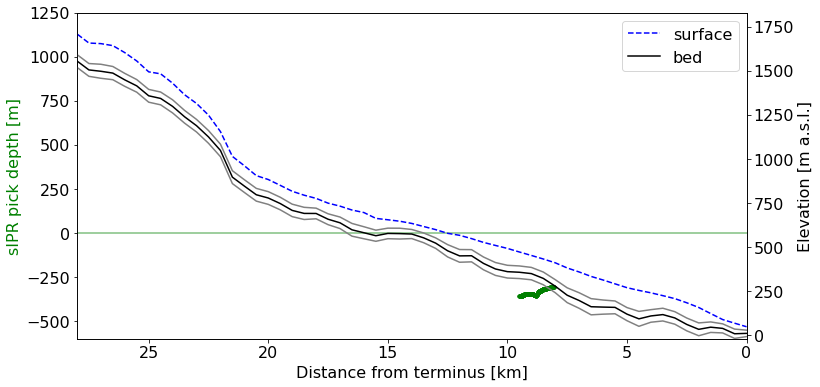

In [308]:
fs = 16
fig, ax = plt.subplots(figsize=(12,6))
twin1 = ax.twinx()

# sIPR transect begins at 9.5 km from terminus
ax.plot(9.5-sIPR_df.sIPR_dist_km_proj/1000, sIPR_df.Pick_depth, 'g.-') # sIPR
ax.plot([30, 0],[0,0],'g-',alpha=0.5)

# Millan:
twin1.plot(Millan_merged_df.dist_m/1000, Millan_surf_df.surface_elev, 'b--') # surface
twin1.plot(Millan_merged_df.dist_m/1000, Millan_merged_df.surface_elev - Millan_merged_df.h, 'k-') # bed elev
# error bars on bed elev:
twin1.plot(Millan_merged_df.dist_m/1000, 
           Millan_merged_df.surface_elev - Millan_merged_df.h - Millan_merged_df.h_err,'-',color='gray')
twin1.plot(Millan_merged_df.dist_m/1000, 
           Millan_merged_df.surface_elev - Millan_merged_df.h + Millan_merged_df.h_err,'-',color='gray',)

# plot params
ax.set_ylabel('sIPR pick depth [m]',color='g',fontsize=fs)
twin1.set_ylabel('Elevation [m a.s.l.]',fontsize=fs)
twin1.legend(['surface','bed'],fontsize=fs)
twin1.tick_params(axis='both', which='major', labelsize=fs)
ax.set_ylim(-600,1850-600)
twin1.set_ylim(-20, 1830)
ax.set_xlabel('Distance from terminus [km]',fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_xlim(28,0)
# ax.grid()

# twin1.plot(prof_df.dist_m/1000, prof_df.mean_elev_diff,'-')
# twin1.set_ylabel('Elevation difference [m]',fontsize=fs)
# twin1.tick_params(axis='both', which='major', labelsize=fs)
plt.show()

# Extract elevations:

In [432]:
dem_path = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/final-DEMs/'
dem_outpath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/'
prof_count = 0

In [334]:
# pull DEM elevations
for file in os.listdir(dem_path):
    if file.endswith('.tif'):
    
        ds = file.split('_')[0]
        print(ds)
        
        # open DEM
        src = rio.open(dem_path+file); elev = src.read(1); affine=src.transform
        
        # extract mean elevations
        dists = []; mean_elev = []
        for idx2, row2 in cline_gdf.iterrows():
            geom = row2.geometry
            dist = row2.distance
            dists.append(dist)
            try:
                out_image, out_transform = mask(src, [mapping(geom)], crop=True)
                crop_array = out_image[0,:,:]
                crop_array[crop_array < -1e3] = np.NaN
#                 print(dist, np.nanmean(crop_array))
                mean_elev.append(np.nanmean(crop_array))
            except Exception:
                mean_elev.append(np.NaN)
#                 print(dist, 'no overlap')
                pass
        mean_elev = np.array(mean_elev); dists = np.array(dists)
        if northline: # flip distances for northern centerline
            dists = np.flip(dists)
            
        
        mean_elev[mean_elev == 0] = np.NaN # differences should never be exactly 0
#         plt.plot(dists/1000, mean_elev, 'o')
#         plt.xlim(0, 30)
#         plt.show()
        
        # write centerline data to csv
        new_df = pd.DataFrame(list(zip(dists, mean_elev)), columns=['dist_m','mean_elev'])
#         print(len(new_df))
        new_df.to_csv(dem_outpath+'centerline_s_250m_'+ds+'.csv')
        
        prof_count+=1
# os.listdir(dem_path)

20140318


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_64473/2927819294.py:22: RuntimeWarning: Mean of empty slice
  mean_elev.append(np.nanmean(crop_array))


20220223
20180128
20180117
201208xx
201801me
20220421
20220522
20190430
bed
20151031
h.tif
herr.tif
20131207
20180507
20200605
20160717
20210717
20211025


In [211]:
# pd.to_datetime(date_list)

# Calculate surface slope

2012-08-15 0.05154169029530425 5.900957770697013e-63
2013-12-07 0.04392848889943658 1.4671108884242902e-69
2014-03-18 0.0395504435421798 2.036401286178894e-33
2015-10-31 0.046242689559322016 2.6366532987619935e-73
2016-07-17 0.04894994118199646 7.292726896863229e-72
2018-01-28 0.05185896091318091 3.946061303638356e-67
2018-05-07 0.052121628687126345 5.278430551551712e-66
2019-04-30 0.05348446311836736 1.8095877835221041e-60
2020-06-05 0.05359156489869408 5.613586696710385e-58
2021-07-17 0.04096093939770323 4.15809234190333e-65
2021-10-25 0.04374627314888032 2.492531551247866e-38
2022-02-23 0.04305226645463041 1.1233652323723475e-72
2022-04-21 0.043369076031862144 6.289067228107082e-73
2022-05-22 0.04372676048861771 4.321797441497824e-74
0.04686608475837869


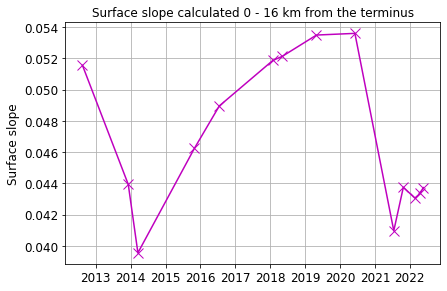

In [336]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
fs = 12
##########
outfigpath = '/Users/jukesliu/Documents/CONFERENCES/2022_IGS_Juneau/'
filelist = os.listdir(dem_outpath); filelist.sort()
#########

# colors
colors = plt.cm.viridis_r(np.linspace(0,1,prof_count))
col_count = 0

# plt.xlim(14,0)
# plt.ylim(-40,400)
plt.grid()
# plt.xlabel('Distance from terminus [km]',fontsize=fs)
# plt.ylabel('Elevation [m a.s.l.]',fontsize=fs)
plt.tick_params(labelsize=fs)
plt.tight_layout()

date_list = []; slopes = []
for elevprofile in filelist:
    if elevprofile.startswith('centerline_n_250m') and elevprofile.endswith('.csv') and '20' in elevprofile:
        elev_df = pd.read_csv(dem_outpath+elevprofile)
        ds = elevprofile.split('_')[-1][:-4]
        
        if 'me' in ds or 'xx' in ds:
            day = '15' # replace the day with a generic half point in the month
        else:
            day = ds[6:8]
        ds_leg = ds[0:4]+'-'+ds[4:6]+'-'+day
#         print(ds_leg)
        
    
        # EVALUATE SURFACE SLOPE AND PLOT
        if ds_leg != '2018-01-17' and ds_leg != '2018-01-15': # incomplete
            surface_slope_df = elev_df[(elev_df.dist_m > 1e3) & (elev_df.dist_m < 16e3)] # between 1.5 and 14 km
            nanmask = ~np.isnan(surface_slope_df.mean_elev)
            
            if len(surface_slope_df.mean_elev[nanmask]) == 0:
                continu
            
            slope, intercept, r, p, std_err = stats.linregress(surface_slope_df.dist_m[nanmask], 
                                                               surface_slope_df.mean_elev[nanmask])  
            print(ds_leg, slope, p)
            slopes.append(slope)
            date_list.append(ds_leg)
#         plt.plot(surface_slope_df.dist_m/1000, surface_slope_df.dist_m*slope+intercept, color=colors[col_count])

        
#         # PLOT ELEVATION PROFILE
#         plt.plot(elev_df.dist_m/1000,elev_df.mean_elev, '-', linewidth=2.5, color=colors[col_count],alpha=0.8)
    
#         # save a figure:
#         plt.savefig(outfigpath+'elev_profile_nterm_'+ds+'.png',dpi=200)
            
        col_count+=1
        
# background_col='xkcd:white'; ax.set_facecolor(background_col)
# plt.gca().axes.get_xaxis().set_ticklabels([])
# plt.legend(date_list,ncol=3,loc='lower right',fontsize=fs, framealpha=1) # legend
plt.plot(pd.to_datetime(date_list), slopes, 'mx-', markersize=10)
plt.ylabel('Surface slope', fontsize=fs)
plt.title('Surface slope calculated 0 - 16 km from the terminus')

ss_df = pd.DataFrame(list(zip(date_list, slopes)), columns=['datetime','slope'])
# ss_df.to_csv(outfigpath+'surface_slopes_0to7km.csv')

print(np.nanmean(slopes))

plt.show()

In [337]:
ss_df

,datetime,slope
0,2012-08-15,0.051542
1,2013-12-07,0.043928
2,2014-03-18,0.039550
3,2015-10-31,0.046243
4,2016-07-17,0.048950
5,2018-01-28,0.051859
6,2018-05-07,0.052122
7,2019-04-30,0.053484
8,2020-06-05,0.053592
9,2021-07-17,0.040961
